<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Techniques for improving training of neural networks
This notebook introduces a few of the common approaches used to both speed up training and reduce overfitting / improve generalization ability of neural networks:  
- [Momentum](#momentum)   
- [Learning rate schedulers](#learning-rate-schedulers)   
- [One-cycle LR policy](#one-cycle-learning-rate-policy)  
- [Batch Normaliation](#batch-normalization)  
- [Dropout](#dropout)

In [1]:
# # Run this cell only if working in Colab
# # Connects to any needed files from GitHub and Google Drive
# import os

# # Remove Colab default sample_data
# !rm -r ./sample_data

# # Clone GitHub files to colab workspace
# repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
# git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
# !git clone "{git_path}"

# # Install dependencies from requirements.txt file
# #!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# # Change working directory to location of notebook
# notebook_dir = '1_intro_neuralnets'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# %cd "{path_to_notebook}"
# %ls

In [2]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Momentum
When we apply momentum during training, we add a term to the gradient descent update equation which helps speed up learning and avoid getting stuck in local minima of the cost function.  The term we add is a factor of the previous weight change, which introduces a smoothing effect to the training.  PyTorch allows us to easily incorporate momentum by specifying a value for momentum when defining the optimizer.

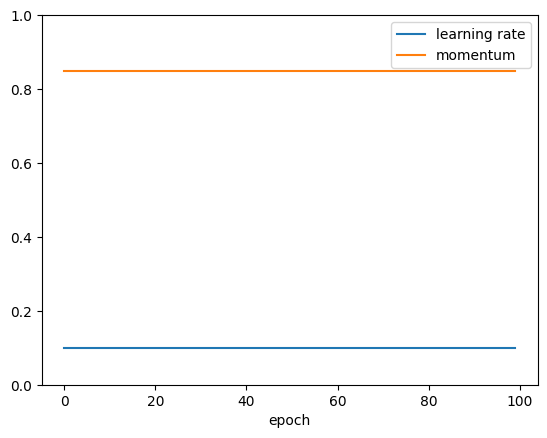

In [3]:
model = torch.nn.Linear(2,1)
optimizer = optim.SGD(model.parameters(), momentum = 0.85, lr=0.1)
n_epochs=100
lr_steps = []
mom_steps = []
for epoch in range(n_epochs):
    optimizer.step()
    lr_steps.append(optimizer.param_groups[0]['lr'])
    mom_steps.append(optimizer.param_groups[0]['momentum'])

plt.plot(lr_steps,label='learning rate')
plt.plot(mom_steps,label='momentum')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend()
plt.show()

## Learning Rate Schedulers
We can use the built-in learning rate schedulers in PyTorch to decay the learning rate over the course of the model training.  There are many different approaches available in PyTorch to decaying the learning rate - below we will use the straightforward `StepLR`, which reduces the learning rate by a factor `gamma` every `step_size` epochs.

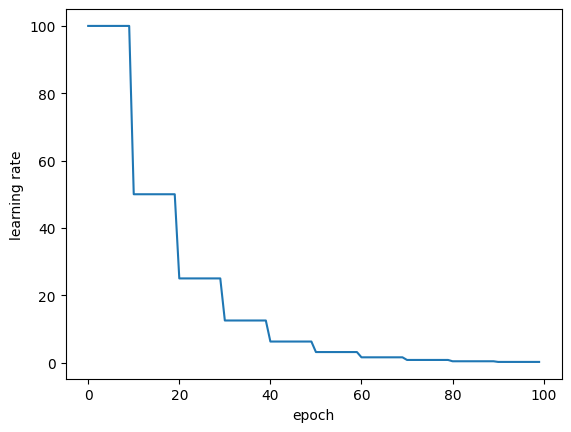

In [4]:
model = torch.nn.Linear(2,1)
optimizer = optim.SGD(model.parameters(), lr=100)
n_epochs=100
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)
lr_steps = []
for epoch in range(n_epochs):
    optimizer.step()
    lr_steps.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.plot(lr_steps)
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

## One Cycle Learning Rate Policy
The 1cycle learning rate policy anneals the learning rate from an initial specified value to some maximum value and then from that maximum down to a minimum value much lower than the initial learning rate.  The 1cycle learning rate policy changes the learning rate after every **batch** (NOT just once per epoch as the learning rate scheduler did).  Momentum is also applied in the 1cycle policy and changes inversely to the learning rate (as we grow the LR, we decrease the momentum) to maintain a balance of regularization during training.

See Smith & Topin's original paper [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/pdf/1708.07120.pdf) for more detail on the 1cycle policy.

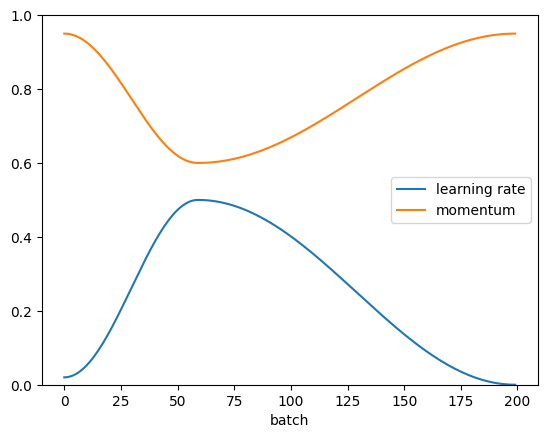

In [5]:
model = torch.nn.Linear(2,1)
optimizer = optim.SGD(model.parameters(), lr=0.1)
n_epochs=10
n_batches = 20
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=0.5,
                                        base_momentum = 0.6,
                                        steps_per_epoch=n_batches,
                                        epochs=n_epochs)
lr_steps = []
mom_steps = []
for epoch in range(n_epochs):
    for batch in range(n_batches):
        optimizer.step()
        lr_steps.append(optimizer.param_groups[0]['lr'])
        mom_steps.append(optimizer.param_groups[0]['momentum'])
        scheduler.step()

plt.plot(lr_steps,label='learning rate')
plt.plot(mom_steps,label='momentum')
plt.ylim(0,1)
plt.xlabel('batch')
plt.legend()
plt.show()

## Example implementation
Let's now take a look at a simple example.  We will train a model four ways and compare the path of the training loss:  
- Vanilla training - fixed learning rate and no momentum  
- Fixed LR with momentum  
- LR scheduler  
- One-cycle policy

We would expect that the use of these forms of regularization would help the network train more quickly and smoothly.

In [6]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Set random seeds
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# Convert training and test data to TensorDatasets
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), 
                         torch.from_numpy(y_train).float())
testset = TensorDataset(torch.from_numpy(X_test_scaled).float(), 
                        torch.from_numpy(y_test).float())

# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [8]:
# Define simple network architecture
class FeedForwardNet(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = torch.sigmoid(self.out(x))
        return x

In [9]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device,lrscheduler=None):
    
    model = model.to(device)
    model.train() # Set the model to training mode
    
    cost = []
    
    for epoch in range(num_iter):

        running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # If one cycle LR policy is used, take step every batch
            if type(lrscheduler) == optim.lr_scheduler.OneCycleLR:
                lrscheduler.step()

            # Add the loss to running loss for the epoch
            running_loss += loss.item()

        cost.append(running_loss)

        # If decaying LR schedule is used, take step every epoch
        if type(lrscheduler) == optim.lr_scheduler.StepLR:
            lrscheduler.step()

    return cost

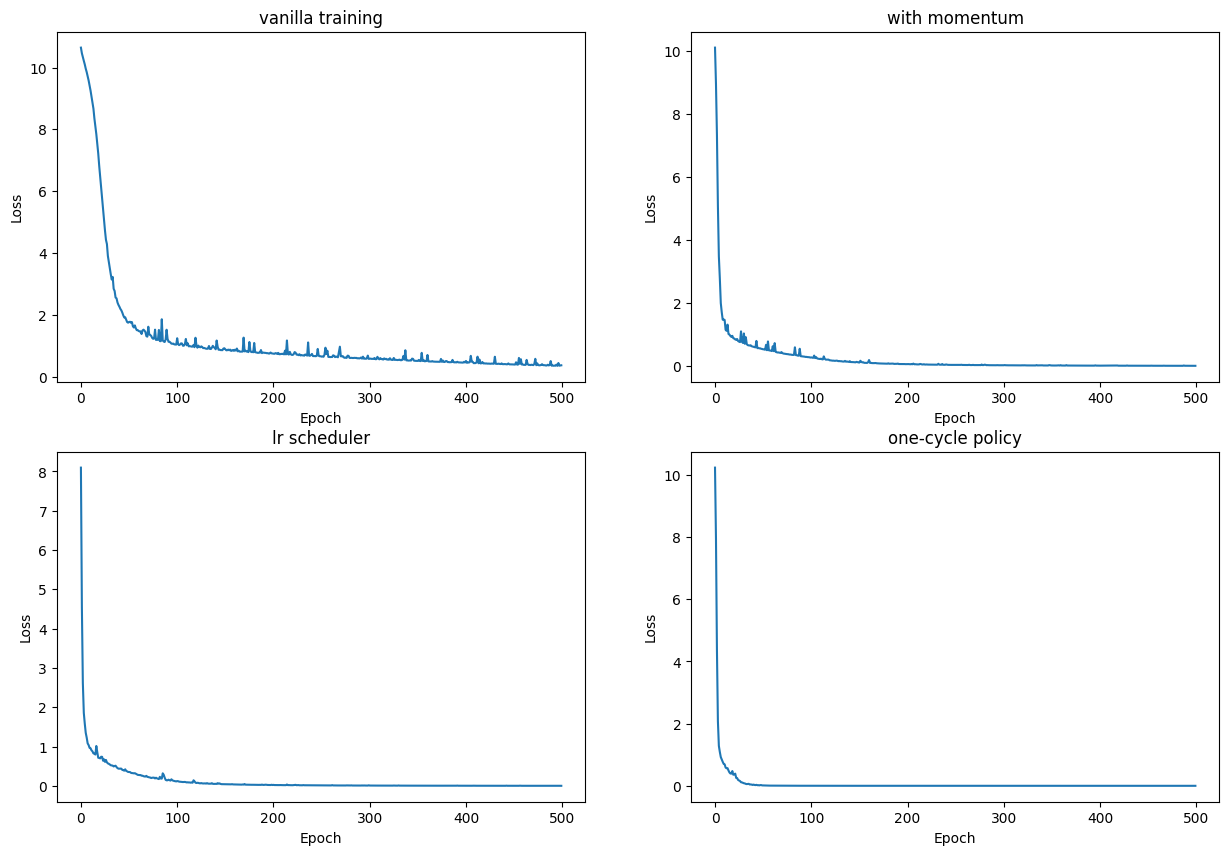

In [10]:
# Define the cost / loss function
criterion = nn.BCELoss()
# Number of iterations (epochs) to train
n_epochs = 500
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Vanilla training
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)
optimizer1 = optim.SGD(net.parameters(), lr=0.01)
cost_path_vanilla = train_model(net,criterion,optimizer1,trainloader,n_epochs,device,lrscheduler=None)

# Train with momentum
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)
optimizer2 = optim.SGD(net.parameters(), momentum=0.85, lr=0.01)
cost_path_momentum = train_model(net,criterion,optimizer2,trainloader,n_epochs,device,lrscheduler=None)

# Train with LR scheduler
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)
optimizer3 = optim.SGD(net.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)
cost_path_scheduler = train_model(net,criterion,optimizer3,trainloader,n_epochs,device,lrscheduler=scheduler)

# Train with 1cycle policy
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)
optimizer4 = optim.SGD(net.parameters(), lr=0.1)
onecycle_scheduler = optim.lr_scheduler.OneCycleLR(optimizer4,
                                        max_lr=0.3,
                                        base_momentum = 0.8,
                                        steps_per_epoch=len(trainloader),
                                        epochs=n_epochs)
cost_path_1cycle = train_model(net,criterion,optimizer4,trainloader,n_epochs,device,lrscheduler=onecycle_scheduler)

# Plot the cost over training
fig,ax = plt.subplots(2,2,figsize=(15,10))
outputs = [cost_path_vanilla,cost_path_momentum,cost_path_scheduler,cost_path_1cycle]
names = ['vanilla training','with momentum','lr scheduler','one-cycle policy']
for i,(cost,name) in enumerate(zip(outputs,names)):
    ax_sub=ax[i//2,i%2]
    ax_sub.plot(cost)
    ax_sub.set_title(name)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

## Batch Normalization
Another common practice in training deep neural networks is the use of batch normalization.  During backpropagation, the weights of each layer are updated under the expectation that the prior layer outputs have a given distribution.  In reality however, the distribution shifts due to variation across batches and updates made to the prior layer weights, which is referred to as internal covariate shift.  This slows the learning of the network and requires lower learning rates.  We can reduce this issue by standizign the inputs of each layer, for each minibatch, so that each layer sees a roughly consistent distribution of inputs.  This is called **batch normalization (batch norm)**.  Generally we apply batch norm to the summed inputs to the layer right before the non-linear activation function is applied.  This can help to significantly speed up and smooth training, and allows us to use a larger initial learning rate.

Read the details on batch normalization in Ioffe and Szegedy's original paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf).

In [11]:
# Define simple network architecture with batch normalization
class FeedForwardNet_BatchNorm(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        self.out = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.bn1(self.hidden1(x)))
        x = F.relu(self.bn2(self.hidden2(x)))
        x = torch.sigmoid(self.out(x))
        return x

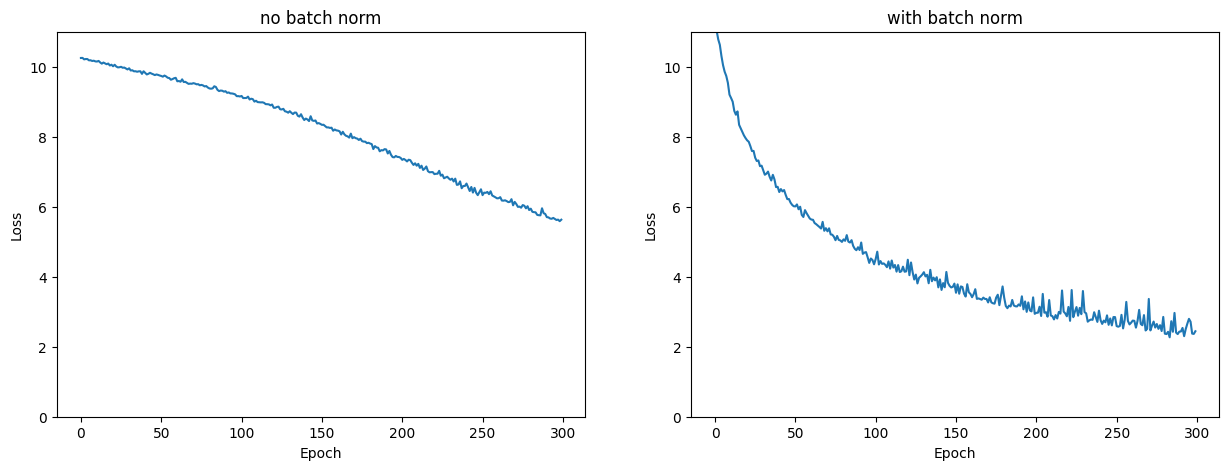

In [12]:
# Define the cost / loss function
criterion = nn.BCELoss()
# Number of iterations (epochs) to train
n_epochs = 300
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Vanilla training
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)
optimizer = optim.SGD(net.parameters(), lr=0.001)
cost_path_vanilla = train_model(net,criterion,optimizer,trainloader,n_epochs,device,lrscheduler=None)

# Use network with batch norm and same LR
net = FeedForwardNet_BatchNorm(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)
optimizer = optim.SGD(net.parameters(), lr=0.001)
cost_path_batchnorm = train_model(net,criterion,optimizer,trainloader,n_epochs,device,lrscheduler=None)

# Plot the cost over training
fig,ax = plt.subplots(1,2,figsize=(15,5))
outputs = [cost_path_vanilla,cost_path_batchnorm]
names = ['no batch norm','with batch norm']
for i,(cost,name) in enumerate(zip(outputs,names)):
    ax_sub=ax[i%3]
    ax_sub.plot(cost)
    ax_sub.set_title(name)
    ax_sub.set_ylim(0,11)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

As we can see above, with the addition of batch normalization our network trains more quickly.  Because our network is very shallow, batch norm is not really necessary in this case and has minimal benefit, but the effects are much more pronounced for very deep networks.

## Dropout
Another strategy to reduce the overfitting issue of neural networks is to create an ensemble of neural network models wtih different architectures.  Ensemble models maintain the bias but reduce variance relative to their individual members, thus reducing overfitting and improving generalization.  Creating an ensemble of neural networks would be computationally expensive, however.  Fortunately, we can make use of a simple technique called **dropout** to simulate using an ensemble of many different network architectures by randomly dropping out nodes in the network during training.  Each node is kept or dropped with a certain probability which is specified when instantiating the model.

Let's take a look at a simple example of how to include dropout in your neural network architecture.  We will train two models, a vanilla network and a network including dropout, and compare the test set accuracy of both.

It's important to note that we apply dropout only during **training** of the model, and **not** when we test it or use it in production.  To turn the dropout layers off, we call `model.eval()` to put the model in evaluate mode, which turns off randomization such as dropout.

Read the details in the original paper by Srivastava et al.: [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

In [13]:
# Define simple network architecture with dropout
class FeedForwardNet_Dropout(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output,dropout_prob=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x))
        return x

Model: vanilla network
Test set accuracy is 0.965

Model: network with dropout
Test set accuracy is 0.939


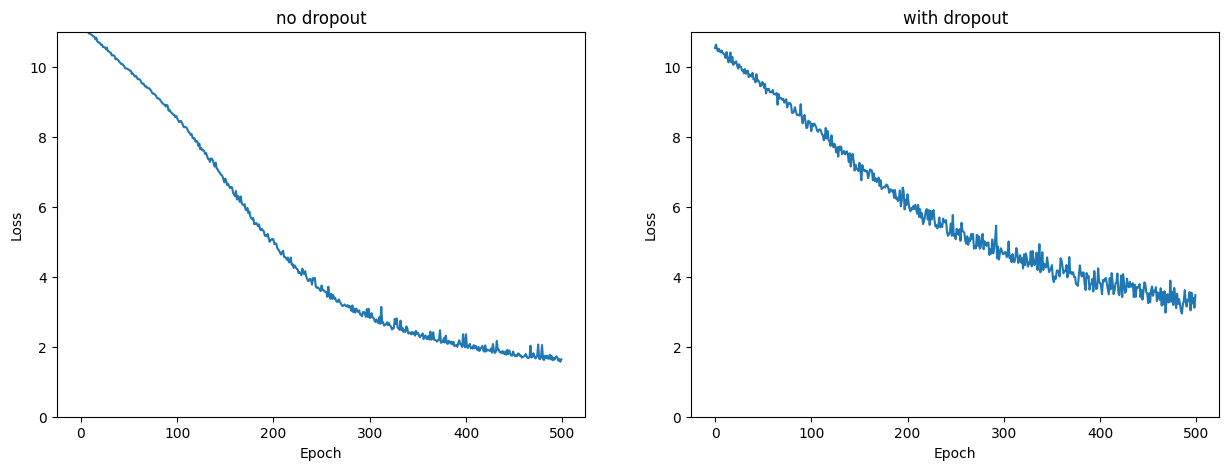

In [14]:
# Define the cost / loss function
criterion = nn.BCELoss()
# Number of iterations (epochs) to train
n_epochs = 500
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Vanilla training
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)
optimizer = optim.SGD(net.parameters(), lr=0.001)
cost_path_vanilla = train_model(net,criterion,optimizer,trainloader,n_epochs,device,lrscheduler=None)

# Calculate test set accuracy
# After training, we set net.eval() to put the network in "evaluate" mode
# which turns dropout OFF
net.eval()
with torch.no_grad():
    y_true = y_test.tolist
    test_preds = []
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net.forward(inputs)
        test_preds.extend(outputs.cpu().squeeze().tolist())
    test_preds = np.round(test_preds)
    test_acc = np.sum(test_preds==y_test)/len(y_test)
    print('Model: vanilla network')
    print('Test set accuracy is {:.3f}'.format(test_acc))
    print()

# Use network with dropout and same LR
net = FeedForwardNet_Dropout(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1,dropout_prob=0.5)
optimizer = optim.SGD(net.parameters(), lr=0.001)
cost_path_dropout = train_model(net,criterion,optimizer,trainloader,n_epochs,device,lrscheduler=None)
# Calculate test set accuracy
net.eval()
with torch.no_grad():
    y_true = y_test.tolist
    test_preds = []
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net.forward(inputs)
        test_preds.extend(outputs.cpu().squeeze().tolist())
    test_preds = np.round(test_preds)
    test_acc = np.sum(test_preds==y_test)/len(y_test)
    print('Model: network with dropout')
    print('Test set accuracy is {:.3f}'.format(test_acc))
plt.show()

# Plot the cost over training
fig,ax = plt.subplots(1,2,figsize=(15,5))
outputs = [cost_path_vanilla,cost_path_dropout]
names = ['no dropout','with dropout']
for i,(cost,name) in enumerate(zip(outputs,names)):
    ax_sub=ax[i%3]
    ax_sub.plot(cost)
    ax_sub.set_title(name)
    ax_sub.set_ylim(0,11)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

In this case, adding dropout did not make much (if any) difference in our test set performance, because we are working with a small dataset and a very shallow model.  However, adding dropout (or batch norm) when building deep neural networks can have a big impact on generalization ability (test set performance).

One impact of dropout which we can see above is that it makes the training process noisier.  We would expect this, because the architecture of the network is changing throughout training.  Although this might seem like a concern, it actually causes the trained model to be more robust and less sensitive to changes in inputs (which is the indication of overfitting)